In [3]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
%pip install yfinance

In [4]:
import yfinance as yf
import datetime
import time
import requests
import io

In [5]:
data = yf.download("^GSPC", start="2000-01-01", end="2021-08-01")

[*********************100%%**********************]  1 of 1 completed


In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [7]:
data.shape

(5429, 6)

In [8]:
train_size = int(0.8*data.shape[0])
print(train_size)

4343


In [9]:
train_data = data.iloc[0:train_size]
test_data = data.iloc[train_size+1:]

We are going to be working with 3 features:
1. The fractional change in opening and closing prices (fracocp)
2. The fractional change in high prices (frachp)
3. The fractional change in low prices (fraclp)


In [10]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)

    return new_dataframe

In [11]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [12]:
features = extract_features(augment_features(train_data))

In [13]:
features.shape

(4343, 3)

In [14]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.5 MB/s eta 0:00:00


In [15]:
from hmmlearn.hmm import GaussianHMM

In [16]:
model = GaussianHMM(n_components=10)

In [17]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)
model.fit(features_train)

GaussianHMM(n_components=10)

In [18]:
import itertools

test_augmented = augment_features(test_data)
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

In [19]:
num_latent_days = 50
num_days_to_predict = 300

In [20]:
from tqdm import tqdm

predicted_close_prices = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 300/300 [10:59<00:00,  2.20s/it]


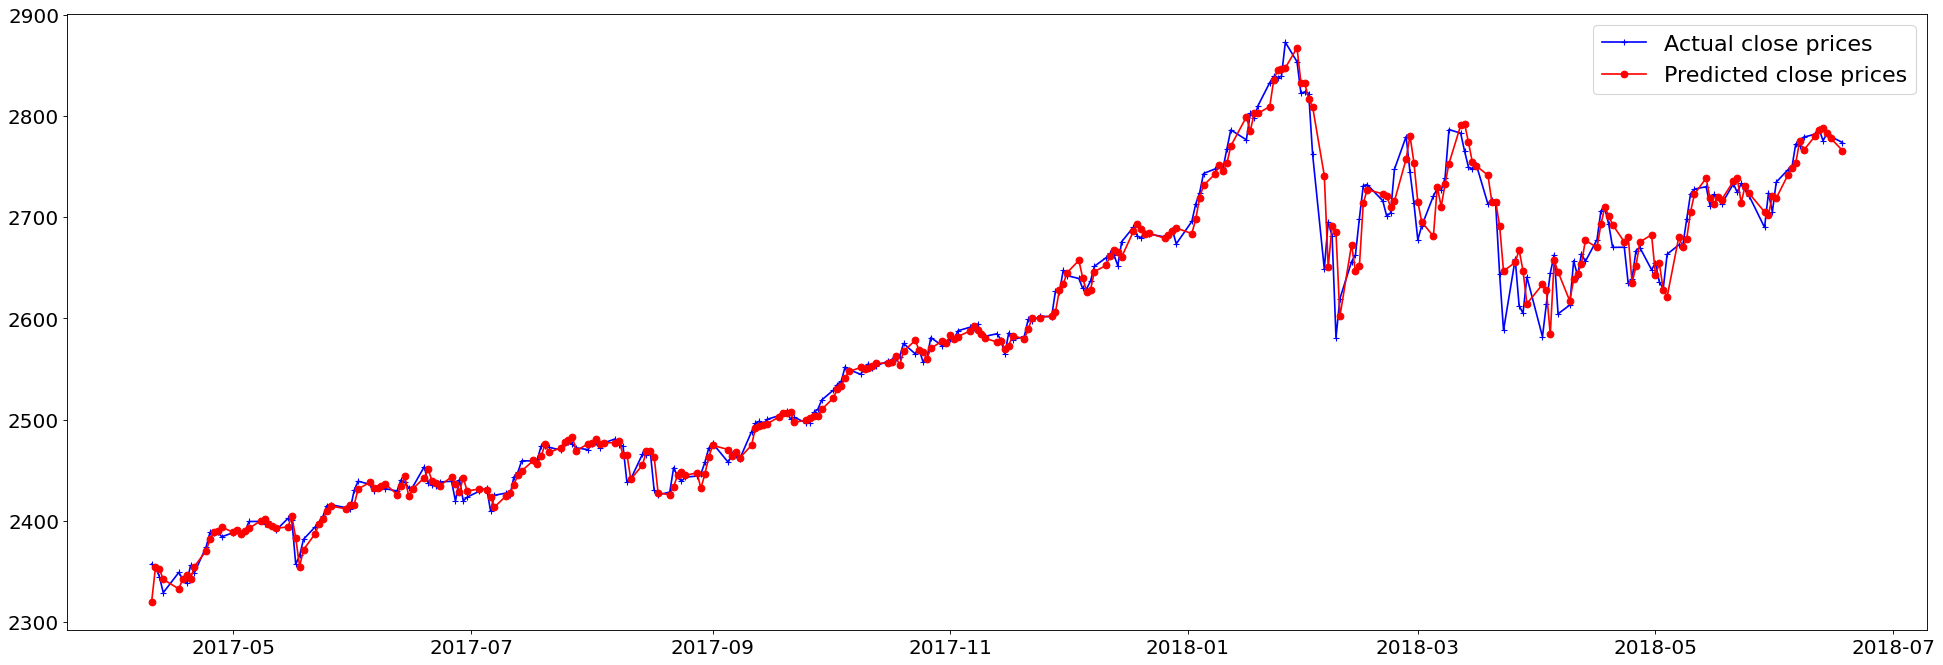

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data.index[0:num_days_to_predict], dtype='datetime64[ms]')
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
plt.legend(prop={'size': 20})
plt.show()

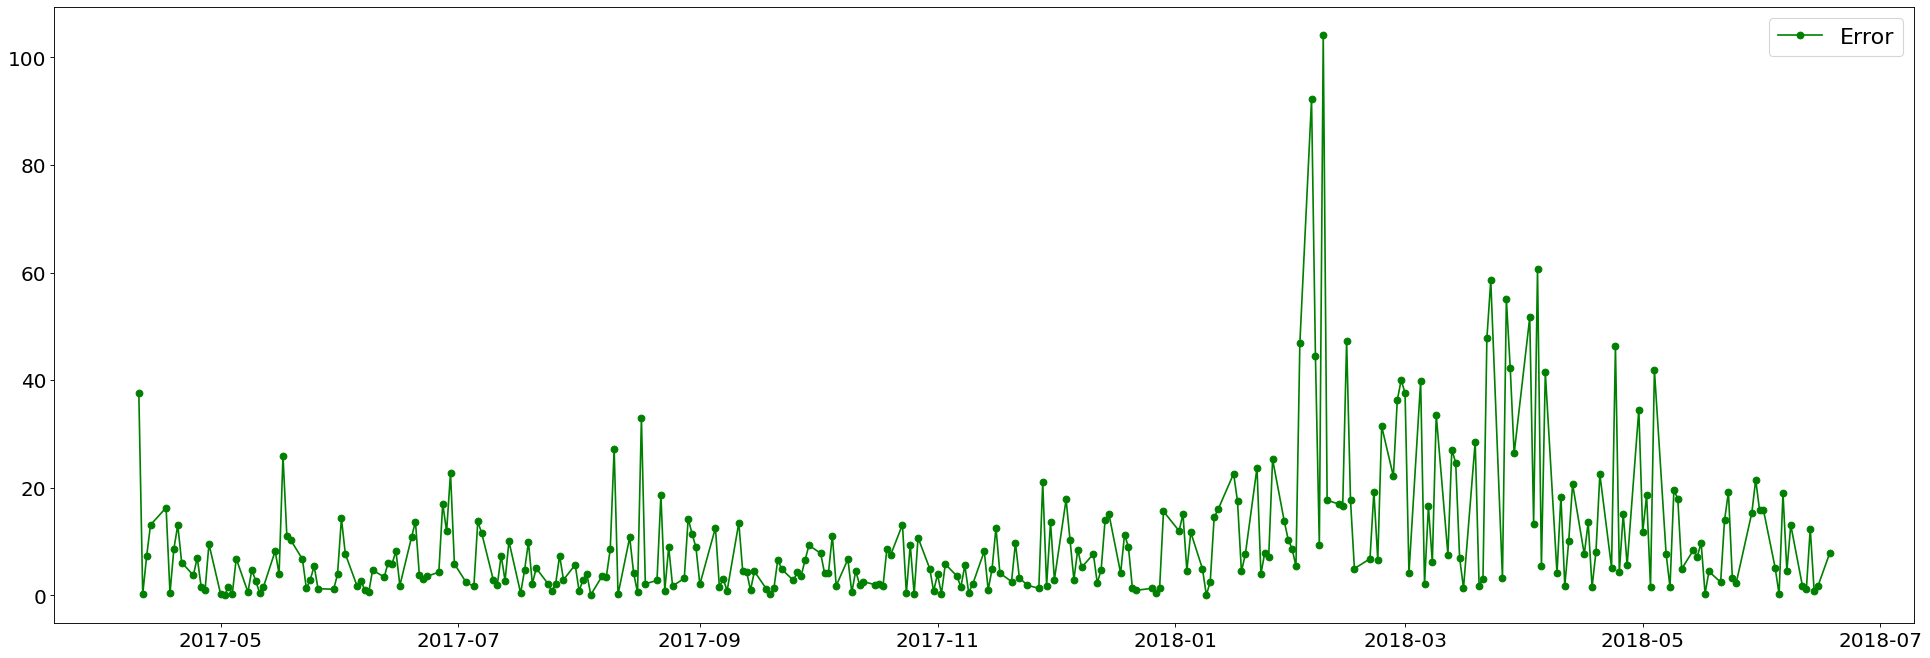

In [22]:
ae = abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)

plt.figure(figsize=(30,10), dpi=80)

plt.plot(x_axis, ae, 'go-', label="Error")
plt.legend(prop={'size': 20})
plt.show()

In [23]:
print("Max error observed = " + str(ae.max()))
print("Min error observed = " + str(ae.min()))
print("Mean error observed = " + str(ae.mean()))

Max error observed = 104.09275716316142
Min error observed = 0.046184990517758706
Mean error observed = 10.390875528804077


In [29]:
num_latent_days_values = [10, 20, 30, 40, 50, 60]
baseline_num_latent_days = 50
n_components_values = [4, 6, 8, 10, 12, 14]
baseline_n_componets = 10
num_steps_values = [10, 20, 40, 50]
baseline_num_steps = 50
num_days_to_predict = 100

In [25]:
mae_num_components = []
for num_component in n_components_values:
    model = GaussianHMM(n_components=num_component)
    model.fit(features_train)
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - baseline_num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_components.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean())


100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


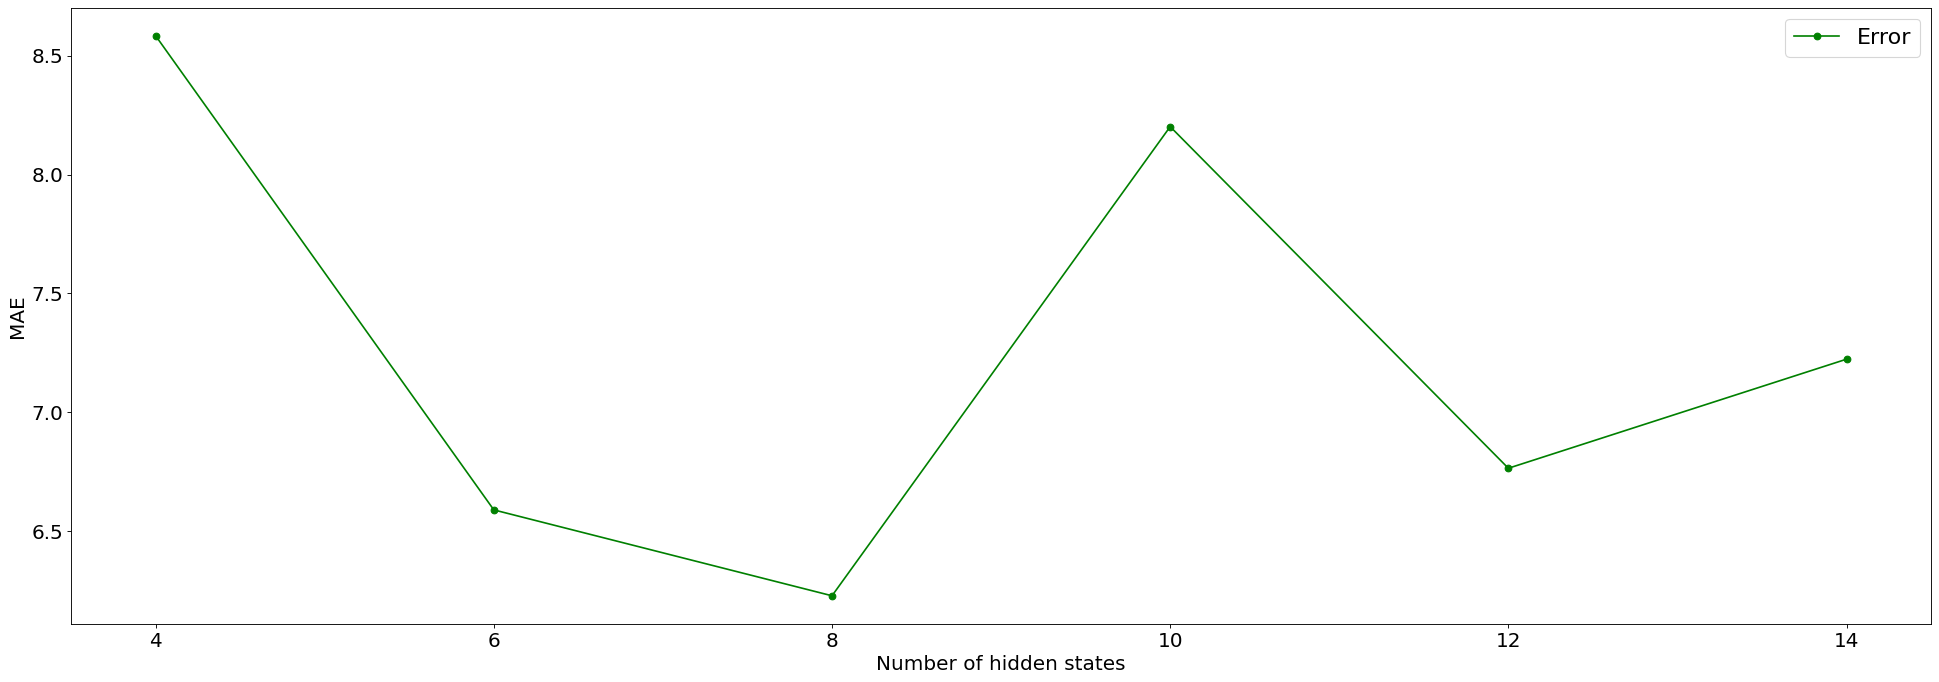

In [26]:
plt.figure(figsize=(30,10), dpi=80)

plt.plot(n_components_values, mae_num_components, 'go-', label="Error")
plt.xlabel("Number of hidden states")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

In [27]:
mae_num_steps = []
model = GaussianHMM(n_components=baseline_n_componets)
model.fit(features_train)
for num_step in num_steps_values:
    sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), num_step)
    sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), int(num_step/5))
    sample_space_frachp = np.linspace(frachp.min(), frachp.max(), int(num_step/5))
    possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - baseline_num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_steps.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean())

100%|██████████| 100/100 [03:38<00:00,  2.19s/it]


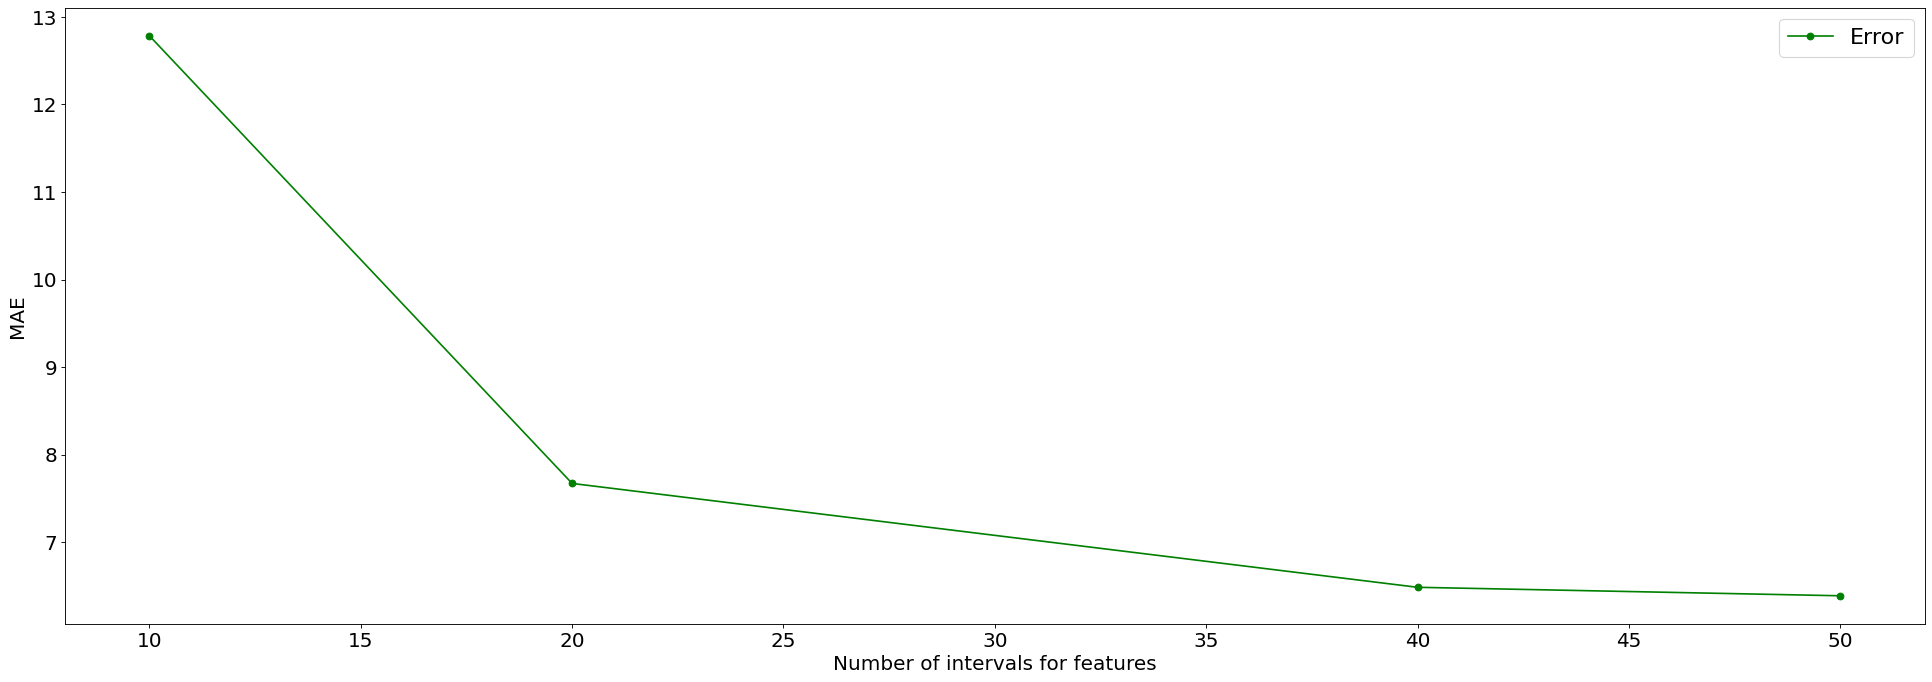

In [28]:
plt.figure(figsize=(30,10), dpi=80)

plt.plot(num_steps_values, mae_num_steps, 'go-', label="Error")
plt.xlabel("Number of intervals for features")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()